In [2]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

In [4]:
# test original CartPoleEnv
import gymnasium as gym
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
# env = gym.make("CartPole-v1", render_mode='human')

env = CartPoleEnv(render_mode='human')
observation, info = env.reset(seed=42)
for _ in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        observation, info = env.reset()
env.close()

Epoch 1/50, Train Loss: 0.108825, Test Loss: 0.022580
Epoch 2/50, Train Loss: 0.012338, Test Loss: 0.001538
Epoch 3/50, Train Loss: 0.003677, Test Loss: 0.000602
Epoch 4/50, Train Loss: 0.001526, Test Loss: 0.000309
Epoch 5/50, Train Loss: 0.000742, Test Loss: 0.000205
Epoch 6/50, Train Loss: 0.000496, Test Loss: 0.000111
Epoch 7/50, Train Loss: 0.000372, Test Loss: 0.000093
Epoch 8/50, Train Loss: 0.000300, Test Loss: 0.000079
Epoch 9/50, Train Loss: 0.000250, Test Loss: 0.000071
Epoch 10/50, Train Loss: 0.000214, Test Loss: 0.000067
Epoch 11/50, Train Loss: 0.000187, Test Loss: 0.000062
Epoch 12/50, Train Loss: 0.000166, Test Loss: 0.000044
Epoch 13/50, Train Loss: 0.000149, Test Loss: 0.000058
Epoch 14/50, Train Loss: 0.000133, Test Loss: 0.000048
Epoch 15/50, Train Loss: 0.000119, Test Loss: 0.000045
Epoch 16/50, Train Loss: 0.000107, Test Loss: 0.000058
Epoch 17/50, Train Loss: 0.000094, Test Loss: 0.000037
Epoch 18/50, Train Loss: 0.000086, Test Loss: 0.000050
Epoch 19/50, Train 

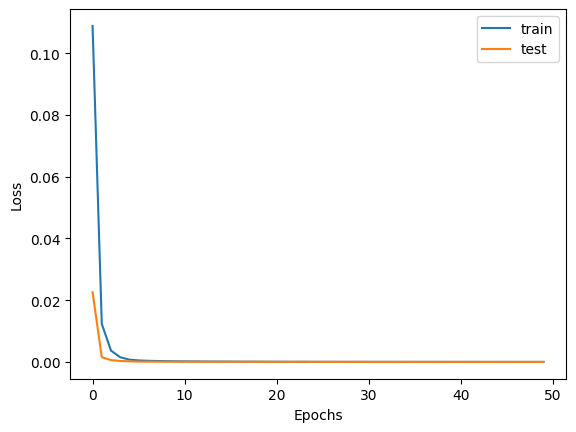

Model training completed successfully. Weights have been saved.


In [5]:
import gymnasium as gym
from models.feedforward_nn import FeedforwardNN
from random_exploration import random_exploration
from train import create_dataloader, train_model

import torch
import os

env = gym.make("CartPole-v1")

# Hyperparameters
NUM_TRAJECTORIES = 100
HORIZON = 50
BATCH_SIZE = 25
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64

# Collect data from the environment
states, actions, next_states = random_exploration(env, NUM_TRAJECTORIES, HORIZON)
# Create DataLoader for training
train_dataloader = create_dataloader(states, actions, next_states, BATCH_SIZE)
# Collect data for test set
states, actions, next_states = random_exploration(env, 1, 500)
# Create DataLoader for training
test_dataloader = create_dataloader(states, actions, next_states, 500)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = 1
model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

# Train the model
train_model(model, train_dataloader, test_dataloader, NUM_EPOCHS, LEARNING_RATE)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), '../weights/baseline_cartpole.pth')
print("Model training completed successfully. "
      "Weights have been saved.")

/tmp/ipykernel_90733/3927713514.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('../weights/baseline_cartpole.pth'))


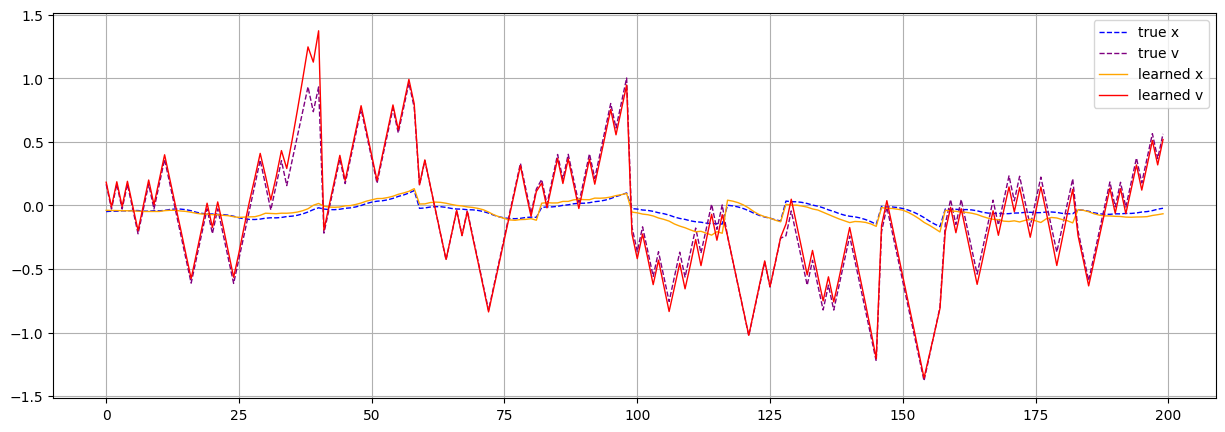

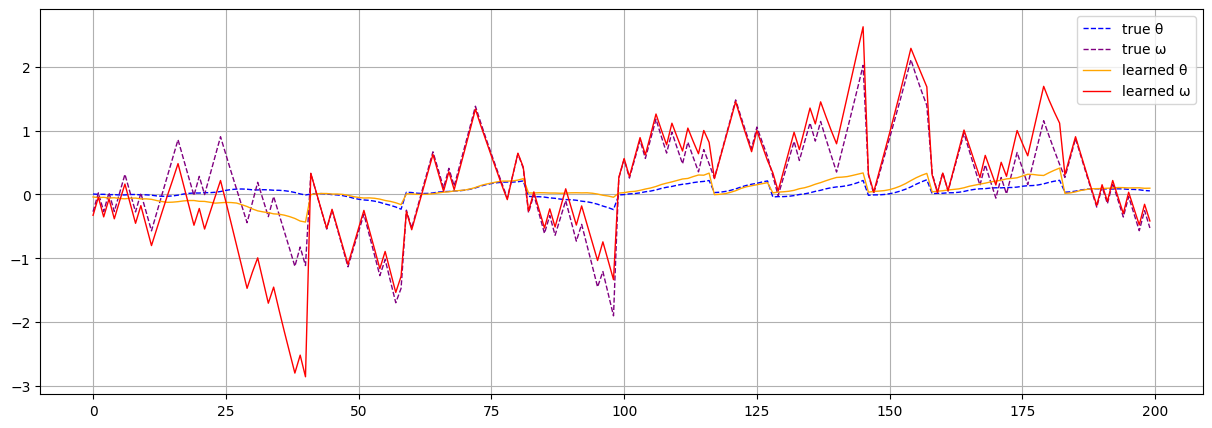

In [6]:
# test model
from dynamical_systems.ModelBasedCartPole import ModelBasedCartPoleEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

if __name__ == "__main__":
    # original dynamic
    env = CartPoleEnv()
    env.reset()
    
    # Initialize trained dynamics model
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    trained_model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

    # load saved weights
    trained_model.load_state_dict(torch.load('../weights/baseline_cartpole.pth'))
    trained_model.eval()

    # learned dynamic
    trained_env = ModelBasedCartPoleEnv(trained_model)
    trained_env.reset()
    env.action_space.seed(test_seed)
    trained_env.action_space.seed(test_seed)

    save = [[],[]]

    for _ in range(200):
        action = env.action_space.sample()
        obs, _, d_true, _, _= env.step(action)
        save[0].append(obs)
        obs, _, d_trained, _, _= trained_env.step(action)
        save[1].append(obs)
        if d_true or d_trained:
            obs,_ = env.reset()
            obs,_ = trained_env.reset()

    saved_traj = np.array(save)
    plt.figure(1, (15,5))
    plt.plot(saved_traj[0,:,0], label="true x", color="blue", linestyle="--", linewidth=1)
    plt.plot(saved_traj[0,:,1], label="true v", color="purple", linestyle="--", linewidth=1)
    plt.plot(saved_traj[1,:,0], label="learned x", color="orange", linewidth=1)
    plt.plot(saved_traj[1,:,1], label="learned v", color="red", linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(2, (15,5))
    plt.plot(saved_traj[0,:,2], label="true θ", color="blue", linestyle="--", linewidth=1)
    plt.plot(saved_traj[0,:,3], label="true ω", color="purple", linestyle="--", linewidth=1)
    plt.plot(saved_traj[1,:,2], label="learned θ", color="orange", linewidth=1)
    plt.plot(saved_traj[1,:,3], label="learned ω", color="red", linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
